In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [2]:
raw_df = pd.read_csv('data/zillow_data.csv')
raw_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


Filter only for Texas
<br>Drop Metro because there were many nulls, and it was redundant with other location data 
<br> Drop regionID and SizeRank because values were specific to Zillow 

In [3]:
raw_df = raw_df[raw_df['State']=='TX']
raw_df.drop(raw_df.columns[np.r_[0,3,4, 6]], axis=1, inplace=True)
raw_df = raw_df.rename(columns={'RegionName': 'zipcode'})


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
#Calculate historical return on investment
raw_df['ROI']= (raw_df['2018-04']/raw_df['1996-04'])-1
raw_df['ROI']


#Calculate standard deviation of monthly values
raw_df['std']=raw_df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
raw_df['mean']=raw_df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
raw_df['CV']=raw_df['std']/raw_df['mean']

#Show calculated values
raw_df[['zipcode','std','mean','ROI','CV']].head()



,zipcode,std,mean,ROI,CV
1,75070,33537.101427,219655.849057,0.365295,0.152680
2,77494,37730.794353,262110.566038,0.567966,0.143950
4,79936,18167.079218,101875.471698,0.571798,0.178326
5,77084,17242.109812,121185.283019,0.729474,0.142279
8,77449,18603.288493,126530.188679,0.846960,0.147026


In [5]:
def melt_data(raw_df):
    melted = pd.melt(raw_df, id_vars=['zipcode', 'City', 'CountyName','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [6]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   zipcode     255096 non-null  int64         
 1   City        255096 non-null  object        
 2   CountyName  255096 non-null  object        
 3   ROI         250160 non-null  float64       
 4   std         255096 non-null  float64       
 5   mean        255096 non-null  float64       
 6   CV          255096 non-null  float64       
 7   date        255096 non-null  datetime64[ns]
 8   value       255096 non-null  float64       
 9   year        255096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 21.4+ MB


In [7]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996
1996-04-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996
1996-04-01,79936,El Paso,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [8]:
df_income = pd.read_csv('data/zip_codes_2019_median_inc.csv')
df_income['state'] = df_income['Preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['Type'] != 'PO box'])
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 31142 to 34261
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ZIP Code                     1839 non-null   int64  
 1   Type                         1839 non-null   object 
 2   State FIPS                   1839 non-null   int64  
 3   Preferred name               1839 non-null   object 
 4   Alternate names              829 non-null    object 
 5   Population (2019)            1718 non-null   object 
 6   Housing units (2019)         1718 non-null   object 
 7   Median family income (2019)  1623 non-null   object 
 8   MFI percentile (2019)        1623 non-null   float64
 9   Latitude                     1718 non-null   float64
 10  Longitude                    1718 non-null   float64
 11  Land area                    1718 non-null   float64
 12  Water area                   1718 non-null   float64
 13  state        

In [9]:
df_income.drop(df_income.columns[np.r_[1:5,6,8,11,12]], axis=1, inplace=True)
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 31142 to 34261
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ZIP Code                     1839 non-null   int64  
 1   Population (2019)            1718 non-null   object 
 2   Median family income (2019)  1623 non-null   object 
 3   Latitude                     1718 non-null   float64
 4   Longitude                    1718 non-null   float64
 5   state                        1839 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 100.6+ KB


Clean up column names

In [10]:
df_income = df_income.rename(columns={'Median family income (2019)': 'median_family_income',
                               'Population (2019)': 'population',
                               'ZIP Code': 'zipcode'})

In [11]:
df_income['median_family_income']

31142         NaN
31143         NaN
31744     $79,551
31745    $105,656
31746     $72,325
           ...   
34257         NaN
34258         NaN
34259         NaN
34260         NaN
34261         NaN
Name: median_family_income, Length: 1839, dtype: object

In [12]:
df_income['median_family_income'] = df_income['median_family_income'].str.strip('$\n\t')
df_income['median_family_income'] = df_income['median_family_income'].str.replace(',','')
df_income  = df_income[df_income['median_family_income'].notna()]
df_income['median_family_income'] = df_income['median_family_income'].astype(int)



 

In [13]:
df_income

,zipcode,population,median_family_income,Latitude,Longitude,state
31744,75001,"14,992",79551,32.959999,-96.838997,TX
31745,75002,"71,253",105656,33.090000,-96.609001,TX
31746,75006,"51,642",72325,32.962002,-96.899002,TX
31747,75007,"55,500",96094,33.005001,-96.897003,TX
31748,75009,"14,089",117857,33.339001,-96.752998,TX
...,...,...,...,...,...,...
34233,79932,"28,243",75676,31.875000,-106.608002,TX
34234,79934,"26,445",71037,31.951000,-106.433998,TX
34235,79935,"17,850",61607,31.768000,-106.329002,TX
34236,79936,"111,620",61016,31.777000,-106.296997,TX


In [14]:
df_income['population'] = df_income['population'].str.replace(',','')
df_income = df_income[df_income['population'].notna()]
df_income['population'] = df_income['population'].astype(int)

In [15]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               1623 non-null   int64  
 1   population            1623 non-null   int64  
 2   median_family_income  1623 non-null   int64  
 3   Latitude              1623 non-null   float64
 4   Longitude             1623 non-null   float64
 5   state                 1623 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 88.8+ KB


In [16]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               1623 non-null   int64  
 1   population            1623 non-null   int64  
 2   median_family_income  1623 non-null   int64  
 3   Latitude              1623 non-null   float64
 4   Longitude             1623 non-null   float64
 5   state                 1623 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 88.8+ KB


In [17]:
df_merged = df.reset_index().merge(df_income, how="left").set_index('date')


In [18]:
df_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,255096.0,77163.777546,1361.342308,75001.000000,76017.000000,77098.000000,78251.000000,7.993800e+04
ROI,250160.0,0.940549,0.418125,-0.375469,0.721048,0.903395,1.101759,6.550360e+00
std,255096.0,23762.532113,16134.709292,2684.773009,13998.832825,19663.932774,29134.083926,1.437548e+05
mean,255096.0,140540.600793,94822.092356,32718.292683,81482.641509,115224.150943,165333.207547,8.802596e+05
CV,255096.0,0.168955,0.040480,0.045182,0.144163,0.166917,0.189818,3.614458e-01
value,255096.0,140540.600793,99061.016727,24100.000000,79900.000000,113700.000000,165100.000000,1.268600e+06
year,255096.0,2006.908003,6.393508,1996.000000,2001.000000,2007.000000,2012.000000,2.018000e+03
population,252181.0,25939.370892,20385.536014,1056.000000,9761.000000,21879.000000,37281.000000,1.282940e+05
median_family_income,252181.0,77689.448301,32642.262099,21169.000000,56108.000000,69722.000000,90867.000000,2.500010e+05
Latitude,252181.0,31.108154,1.797547,25.944000,29.736000,30.805000,32.723999,3.604600e+01


# Filtering

Get IQR of data based on salaries  

In [19]:
# Select the first quantile
q1 = df_merged['value'].quantile(.25)

# Select the third quantile
q3 = df_merged['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered =df_merged[(df_merged['value']>=q1) 
             & (df_merged['value']<=q3)]
df_merged = pd.DataFrame(filtered)
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state
date,,,,,,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004,TX
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,TX
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,TX
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,TX
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018,1871.0,78438.0,35.007000,-101.393997,TX
2018-04-01,77577,Liverpool,Brazoria,1.457990,22188.730901,96658.867925,0.229557,149200.0,2018,1481.0,76382.0,29.284000,-95.281998,TX
2018-04-01,77663,Kountze,Hardin,0.727907,17632.899715,120896.226415,0.145852,148600.0,2018,NaN,NaN,NaN,NaN,NaN


**Create Affordability Score**

In [20]:
df_merged['median_house_price'] = df_merged.groupby('date').aggregate({'value':'median'})
 

In [21]:
df_merged['affordability'] = df_merged['value'] -df_merged['median_family_income']/.12

In [22]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
df_merged['affordability_score']  = normalize_data(df_merged['affordability'])
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004,TX,106600.0,-492166.666667,0.591511
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,TX,106600.0,-593900.000000,0.484277
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,TX,106600.0,-692208.333333,0.380652
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,TX,106600.0,-874791.666667,0.188196
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,TX,106600.0,-912691.666667,0.148247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018,1871.0,78438.0,35.007000,-101.393997,TX,123500.0,-569250.000000,0.510260
2018-04-01,77577,Liverpool,Brazoria,1.457990,22188.730901,96658.867925,0.229557,149200.0,2018,1481.0,76382.0,29.284000,-95.281998,TX,123500.0,-487316.666667,0.596623
2018-04-01,77663,Kountze,Hardin,0.727907,17632.899715,120896.226415,0.145852,148600.0,2018,NaN,NaN,NaN,NaN,NaN,123500.0,NaN,NaN


In [23]:
top_20 = df_merged['affordability_score'].quantile(.2)
df_merged_20 = df_merged[(df_merged['affordability_score'] <top_20)] 
df_merged_20 = df_merged['2017-01-01':].dropna()
df_merged_20.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6653 entries, 2017-01-01 to 2018-04-01
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               6653 non-null   int64  
 1   City                  6653 non-null   object 
 2   CountyName            6653 non-null   object 
 3   ROI                   6653 non-null   float64
 4   std                   6653 non-null   float64
 5   mean                  6653 non-null   float64
 6   CV                    6653 non-null   float64
 7   value                 6653 non-null   float64
 8   year                  6653 non-null   int64  
 9   population            6653 non-null   float64
 10  median_family_income  6653 non-null   float64
 11  Latitude              6653 non-null   float64
 12  Longitude             6653 non-null   float64
 13  state                 6653 non-null   object 
 14  median_house_price    6653 non-null   float64
 15  aff

In [24]:
#Descriptive statistics of coefficients of variance.
print(df_merged_20.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df_merged_20.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
df_20_cv = df_merged_20[df_merged_20['CV']<upper_cv] 

df_20_cv = df_20_cv.reset_index()
df_20_cv = df_20_cv.loc[df_20_cv.groupby("zipcode")["ROI"].idxmax()].sort_values('ROI',axis=0,ascending=False)[:5]
df_20_cv.set_index('date',inplace=True)
df_20_cv

count    6653.000000
mean        0.171711
std         0.037776
min         0.084827
25%         0.148609
50%         0.172273
75%         0.190743
max         0.315077
Name: CV, dtype: float64

CV upper limit: 0.1800214408178011


,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2017-01-01,77020,Houston,Harris,1.641221,11250.658795,65907.924528,0.170703,83200.0,2017,26357.0,35034.0,29.773001,-95.314003,TX,120400.0,-208750.000000,0.890253
2018-03-01,76104,Fort Worth,Tarrant,1.304225,9298.895970,54346.415094,0.171104,80200.0,2018,18344.0,36300.0,32.729000,-97.318001,TX,123300.0,-222300.000000,0.875971
2017-01-01,75062,Irving,Dallas,1.261283,20861.130887,117610.566038,0.177375,155800.0,2017,49306.0,61189.0,32.847000,-96.958000,TX,120400.0,-354108.333333,0.737035
2017-01-01,75050,Grand Prairie,Dallas,1.260028,17806.245475,99366.792453,0.179197,138200.0,2017,43174.0,61583.0,32.772999,-97.004997,TX,120400.0,-374991.666667,0.715022
2017-01-01,75956,Kirbyville,Jasper,1.255220,11219.508619,65782.264151,0.170555,89400.0,2017,8937.0,57196.0,30.676001,-93.983002,TX,120400.0,-387233.333333,0.702119


# EDA

Create DataFrame to perform stationarity checks and transformations

In [25]:
zipcodes =[77020, 76104, 75062, 75050, 75956]
df_merged = df_merged[df_merged['zipcode'].isin(zipcodes)]
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,75062,Irving,Dallas,1.261283,20861.130887,117610.566038,0.177375,84200.0,1996,49306.0,61189.0,32.847000,-96.958000,TX,106600.0,-425708.333333,0.661563
1996-05-01,75062,Irving,Dallas,1.261283,20861.130887,117610.566038,0.177375,84500.0,1996,49306.0,61189.0,32.847000,-96.958000,TX,106400.0,-425408.333333,0.661879
1996-06-01,75062,Irving,Dallas,1.261283,20861.130887,117610.566038,0.177375,84800.0,1996,49306.0,61189.0,32.847000,-96.958000,TX,106350.0,-425108.333333,0.662196
1996-07-01,75062,Irving,Dallas,1.261283,20861.130887,117610.566038,0.177375,85100.0,1996,49306.0,61189.0,32.847000,-96.958000,TX,106300.0,-424808.333333,0.662512
1996-08-01,75062,Irving,Dallas,1.261283,20861.130887,117610.566038,0.177375,85500.0,1996,49306.0,61189.0,32.847000,-96.958000,TX,106200.0,-424408.333333,0.662933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-01,75956,Kirbyville,Jasper,1.255220,11219.508619,65782.264151,0.170555,97200.0,2018,8937.0,57196.0,30.676001,-93.983002,TX,123300.0,-379433.333333,0.710340
2018-04-01,75050,Grand Prairie,Dallas,1.260028,17806.245475,99366.792453,0.179197,163400.0,2018,43174.0,61583.0,32.772999,-97.004997,TX,123500.0,-349791.666667,0.741585
2018-04-01,77020,Houston,Harris,1.641221,11250.658795,65907.924528,0.170703,103800.0,2018,26357.0,35034.0,29.773001,-95.314003,TX,123500.0,-188150.000000,0.911967


In [26]:
df_prices = pd.DataFrame(df_merged[['zipcode', 'value']], index = df_merged.index)
df_prices.reset_index(inplace=True)

In [27]:
df_p = df_prices.pivot("date", "zipcode", "value")
df_p

zipcode,75050,75062,75956,76104,77020
date,,,,,
1996-04-01,NaN,84200.0,NaN,NaN,NaN
1996-05-01,NaN,84500.0,NaN,NaN,NaN
1996-06-01,NaN,84800.0,NaN,NaN,NaN
1996-07-01,NaN,85100.0,NaN,NaN,NaN
1996-08-01,NaN,85500.0,NaN,NaN,NaN
...,...,...,...,...,...
2017-12-01,155500.0,NaN,95300.0,NaN,96500.0
2018-01-01,158900.0,NaN,95300.0,NaN,97800.0
2018-02-01,161100.0,NaN,96200.0,NaN,99200.0


In [28]:
df_p.columns

Int64Index([75050, 75062, 75956, 76104, 77020], dtype='int64', name='zipcode')

# Zipcode 75050

In [29]:
df_75050 = pd.DataFrame(df_p[75050][df_p[75050].notnull()]).astype(int).reset_index()
df_75050['value'] = df_75050[75050] 
df_75050.drop(df_75050.columns[np.r_[1]], axis=1, inplace=True)



In [30]:
df_75050.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    231 non-null    datetime64[ns]
 1   value   231 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.7 KB


Trend Analysis

<AxesSubplot:xlabel='date'>

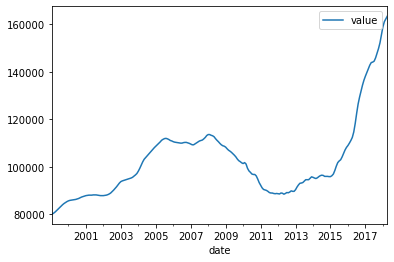

In [31]:
df_mean = df_75050.groupby('date').aggregate({'value':'mean'})
df_mean.plot()

<AxesSubplot:xlabel='date'>

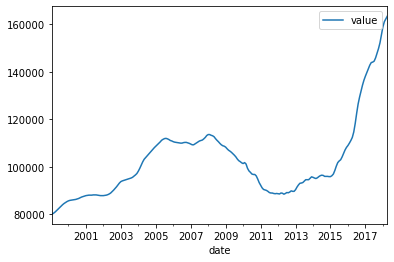

In [32]:
df_std = df_75050.groupby('date').aggregate({'value':'median'})
df_std.plot()

In [33]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

In [34]:
df_75050.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    231 non-null    datetime64[ns]
 1   value   231 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.7 KB


In [35]:
df_75050.set_index(df_75050['date'], inplace=True)
df_75050.drop(df_75050.columns[np.r_[0]], axis=1, inplace=True)


In [36]:
df_75050

,value
date,
1999-02-01,80200
1999-03-01,80600
1999-04-01,81100
1999-05-01,81700
1999-06-01,82300
...,...
2017-12-01,155500
2018-01-01,158900
2018-02-01,161100


Results of Dickey-Fuller Test: 

Test Statistic                  -1.596342
p-value                          0.485431
#Lags Used                      13.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


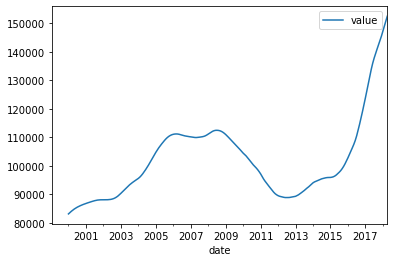

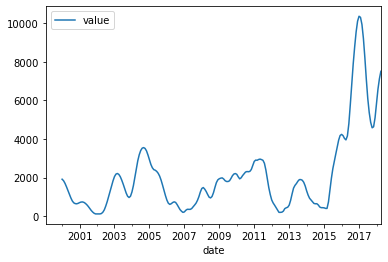

In [37]:
stationarity_check(df_75050)

**Log Transformations**

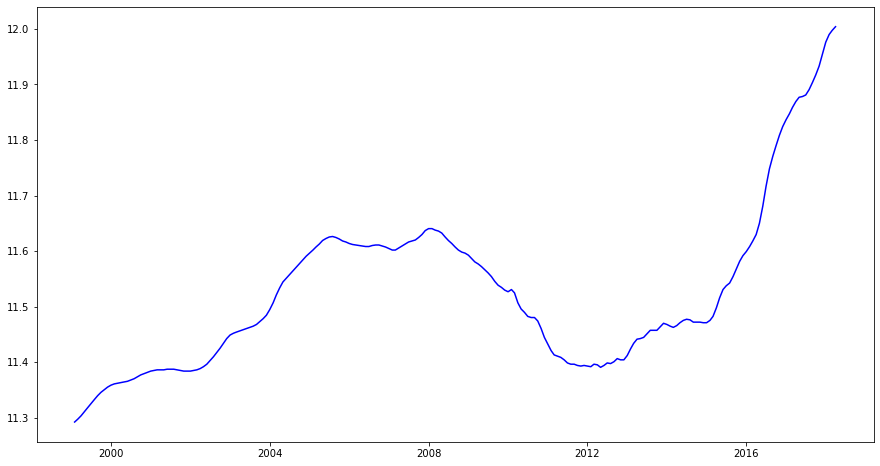

In [38]:
df_log = np.log(df_75050)
fig = plt.figure(figsize=(15,8))
plt.plot(df_log, color='blue');


**Weighted Rolling Mean**

<AxesSubplot:xlabel='date'>

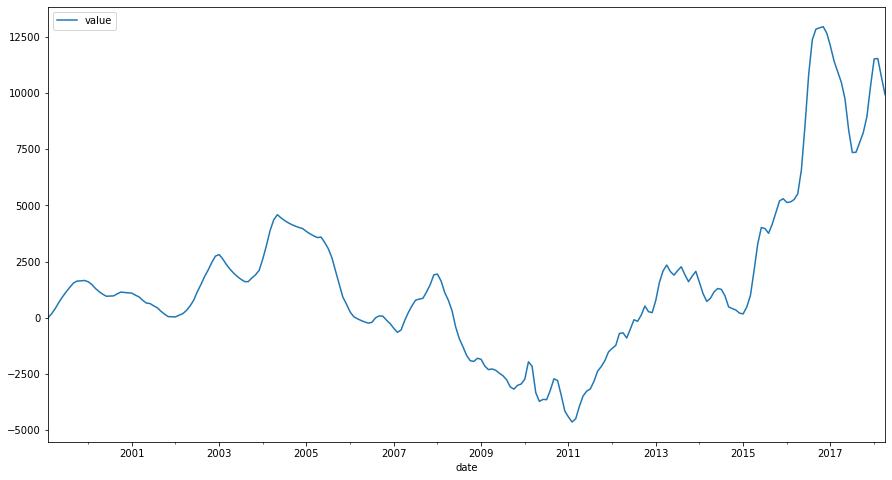

In [39]:
weight_roll_mean = df_75050.ewm(halflife=4).mean()
df_log_wrm = df_75050 - weight_roll_mean
df_log_wrm.plot(figsize=(15,8))



In [40]:
type(df_log_wrm.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [41]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(df_log_wrm, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  231
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1734.961
Date:                Wed, 06 Oct 2021   AIC                           3475.921
Time:                        11:53:00   BIC                           3486.249
Sample:                    02-01-1999   HQIC                          3480.087
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1638.7314   9183.625      0.178      0.858   -1.64e+04    1.96e+04
ar.L1          0.9962      0.006    164.700      0.000       0.984       1.008
sigma2      1.916e+05   1.06e+04     17.988      0.0

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
